# Path Segmentation

## Set-up

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.9MB 5.7MB/s 
     |████████████████████████████████| 102kB 5.6MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 133kB 35.4MB/s 
     |████████████████████████████████| 163kB 37.5MB/s 
     |████████████████████████████████| 71kB 10.1MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74842 sha256=d55cb270b6c45e1f5d71e6160b95702eb397b788711f05d875cce06ef685478f
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6490 sha256=5a46f7368387b60441bb5eea4985eedbc4e903a090792e7ac4d8aac48f3b12da
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=663c3d4b6eaf9c254f99a9758eb8065f935cb1311a97

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 51.7MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision import *
from PIL import Image as PImage

In [ ]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='path-segmentation')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

In [ ]:
path = '/gdrive/My Drive/Labeling/Segmentation'
image_path = os.path.join(path, 'Data', 'Original')
mask_path = os.path.join(path, 'Data', 'EnumMasks', 'png_0_1')
folder_path = os.path.join(path, 'v4')

get_image_label = lambda x: os.path.join(mask_path, f'{x.stem}_P.png')

In [ ]:
train_images = np.loadtxt(os.path.join(folder_path, 'train.txt'), dtype=str)
test_images = np.loadtxt(os.path.join(folder_path, 'test.txt'), dtype=str)
print(len(train_images), len(test_images))

452 63


#### Get data

- Total images: 515
- Training / validation set: 452 / 515 = 87.77%
- Testing set: 12.23%

To have the validation set be 15% of the entire dataset:
- `percent_validation_of_training * percent_training = percent_validation`
- `percent_validation_of_training * .8777 = .15`
- `percent_validation_of_training = 17.09%`

In [ ]:
# Image size
img_f = get_image_files(image_path)[0]
mask = open_mask(get_image_label(img_f))
src_size = np.array(mask.shape[1:])
size = src_size//2

# Batch size
bs = 1

# Class names
codes = np.loadtxt(os.path.join(path, 'codes.txt'), dtype=str)
codes

array(['Path,', 'Other'], dtype='<U5')

In [ ]:
np.random.seed(42)
data = (SegmentationItemList
        .from_folder(image_path)
        .filter_by_func(lambda fname: os.path.split(fname)[1] in train_images)
        .split_by_rand_pct(0.171)
        .label_from_func(get_image_label, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

375 375
77 77


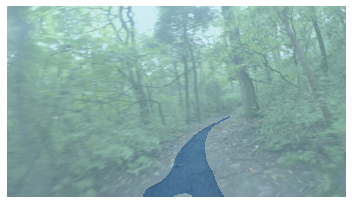

In [ ]:
data.show_batch(figsize=(5,5))

#### Learner

In [ ]:
wd=1e-2

In [ ]:
def acc_segmentation(input, target):
  target = target.squeeze(1)
  return (input.argmax(dim=1)==target).float().mean()

def dice_iou(input, target):
  return dice(input, target, iou=True)

metrics = [acc_segmentation, dice_iou]

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, callback_fns=WandbCallback)
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


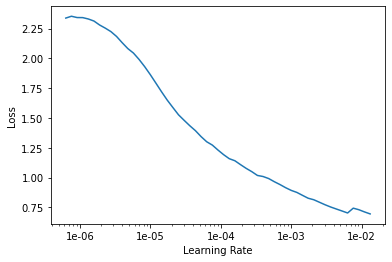

In [ ]:
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(8, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.072063,0.100258,0.959769,0.958207,07:11
1,0.100509,0.103148,0.964165,0.962999,06:01
2,0.093617,0.117454,0.954962,0.953187,06:01
3,0.094302,0.116736,0.963078,0.962013,06:01
4,0.101807,0.112130,0.962272,0.960899,06:01
5,0.074938,0.123690,0.951094,0.949171,06:01
6,0.126300,0.122251,0.952327,0.950429,06:00
7,0.095335,0.113183,0.963375,0.962072,06:00


Better model found at epoch 0 with valid_loss value: 0.10025849938392639.
Loaded best saved model from /content/wandb/run-20210105_033330-1qic8ltd/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v4-stage-1'))

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v4-stage-1'))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


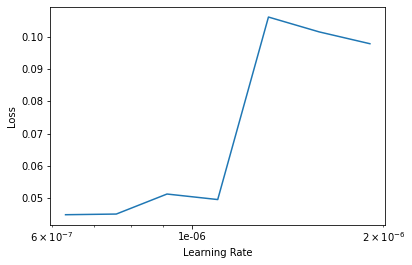

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, slice(lr/1000, lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.082079,0.094152,0.967994,0.966748,09:05
1,0.093260,0.106534,0.954118,0.952222,06:13
2,0.083934,0.080677,0.969413,0.968128,06:13
3,0.062266,0.082915,0.963211,0.961368,06:13
4,0.080042,0.080340,0.972018,0.970732,06:13
5,0.065616,0.073969,0.974405,0.973129,06:13
6,0.056666,0.075063,0.970891,0.969343,06:13
7,0.056666,0.065272,0.975814,0.974498,06:14


Better model found at epoch 0 with valid_loss value: 0.09415193647146225.
Better model found at epoch 2 with valid_loss value: 0.08067700266838074.
Better model found at epoch 4 with valid_loss value: 0.08034049719572067.
Better model found at epoch 5 with valid_loss value: 0.07396866381168365.
Better model found at epoch 7 with valid_loss value: 0.06527189910411835.
Loaded best saved model from /content/wandb/run-20210105_151931-12wqlboa/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v4-stage-2'))

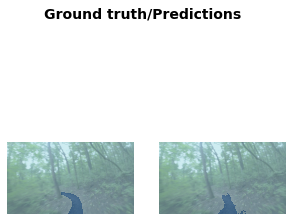

In [ ]:
learn.show_results(rows=1, figsize=(5, 5))

In [ ]:
learn.fit_one_cycle(2, slice(lr/1000, lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.048849,0.064589,0.974541,0.973186,06:13
1,0.047489,0.058276,0.975847,0.974482,06:13


Better model found at epoch 0 with valid_loss value: 0.06458903849124908.
Better model found at epoch 1 with valid_loss value: 0.05827579274773598.
Loaded best saved model from /content/wandb/run-20210105_151931-12wqlboa/files/bestmodel.pth


In [ ]:
learn.save(os.path.join(folder_path, 'v4-stage-2'))

In [ ]:
learn.fit_one_cycle(2, slice(lr/1000, lr/10), pct_start=0.8)

epoch,train_loss,valid_loss,acc_segmentation,dice_iou,time
0,0.046156,0.064545,0.976190,0.974852,06:13
1,0.042162,0.069919,0.978759,0.977586,06:13


Better model found at epoch 0 with valid_loss value: 0.06454513221979141.
Loaded best saved model from /content/wandb/run-20210105_151931-12wqlboa/files/bestmodel.pth


## Evaluate on the test set

In [ ]:
learn.load(os.path.join(folder_path, 'v4-stage-2'))

#### Make and visualize predictions on the test set

In [ ]:
pred_path = os.path.join(path, 'Data', 'Predictions_v4')
get_pred_path = lambda x: f'{pred_path}/{os.path.splitext(x)[0]}_Pred.png'
get_mask_path = lambda x: f'{mask_path}/{os.path.splitext(x)[0]}_P.png'

count = 0
for filename in test_images:
  infile = os.path.join(image_path, filename)
  if os.path.isdir(infile) or os.path.splitext(infile)[1] != '.jpg':
    continue
  
  # Make prediction
  img = open_image(infile)
  pred = learn.predict(img)

  # Convert mask to [0, 255]
  mask_pred = pred[2].argmax(dim=0)
  mask_pred = mask_pred.numpy()
  rescaled = (255.0/mask_pred.max() * mask_pred - mask_pred.min())
  
  # Resize to 2x
  im = PImage.fromarray(rescaled)
  im = im.convert('L')
  im = im.resize((im.width * 2, im.height * 2))

  # Resize changes some pixels to grey, convert back to [0, 255]
  pixels = np.array(im)
  threshold = 255/2
  pixels[pixels <= threshold] = 0
  pixels[pixels > threshold] = 255

  # Save mask
  im = PImage.fromarray(pixels)
  im.save(get_pred_path(filename))

  # Visualize image with predicted and correct overlay
  _, axs = plt.subplots(1,3, figsize=(15,15))

  lbl_mask = open_mask(get_mask_path(filename))
  pred_mask = open_mask(get_pred_path(filename))

  img.show(ax=axs[0])
  img.show(ax=axs[1], y=lbl_mask)
  img.show(ax=axs[2], y=pred_mask)
  plt.show()

  count += 1
  if count % 10 == 0:
    print(count, '/', len(test_images))

Output hidden; open in https://colab.research.google.com to view.

#### Evaluate metrics from predictions on the test set

In [ ]:
np.random.seed(42)
data_test = (SegmentationItemList
            .from_folder(image_path)
            .filter_by_func(lambda fname: os.path.split(fname)[1] in test_images)
            .split_by_rand_pct(1.0)
            .label_from_func(get_image_label, classes=codes)
            .transform(get_transforms(do_flip=False), size=size, tfm_y=True)
            .databunch(bs=1)
            .normalize(imagenet_stats))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:458: UserWarning: Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.
  warn("Your training set is empty. If this is by design, pass `ignore_empty=True` to remove this warning.")


In [ ]:
learn.data = data_test

In [ ]:
preds, ys = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
acc_segmentation(preds, ys)

tensor(0.9715)

In [ ]:
dice_iou(preds, ys)

tensor(0.9704)

In [ ]:
dice(preds, ys)

tensor(0.9848)